In [109]:
import torch
import numpy as np
from sam2.build_sam import build_sam2_video_predictor
from utils.videos_helpey import *
from matplotlib import pyplot as plt
from PIL import Image
import os, glob, shutil

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# BUG: Use the sam2/configs/sam2.1/sam2.1_hiera_b+.yaml in the folder of site-packages
# not the relative path of the working directory
model_cfg = './configs/sam2.1/sam2.1_hiera_b+.yaml'

In [110]:
# Load the model
sam2_ckpt = './sam2ckpts/sam2.1_hiera_base_plus.pt'
predictor = build_sam2_video_predictor(model_cfg, sam2_ckpt,device)

# Load the data
reference_folder = 'data/llff/reference_image'
exp_name = 'horns_center'
reference_dir = os.path.join( reference_folder, exp_name)
suffix = ('jpeg', 'jpg', 'JPG', 'JPEG')

masks_folder = 'data/llff/masks'
masks_dir = os.path.join(masks_folder, exp_name)

scribbles_folder = 'data/llff/scribbles'
scribbles_dir = os.path.join(scribbles_folder, exp_name)

# preparation
logs_path = './logs'
if not os.path.exists(logs_path):
    os.mkdir(logs_path)
video_dir = os.path.join(logs_path, exp_name)
if not os.path.exists(video_dir):
    os.mkdir(video_dir)

def trans_frames_name(src, dst, new_name, suffix=('jpeg', 'jpg', 'JPG', 'JPEG')):
    for f in os.listdir(src): 
        if f.endswith(suffix):
            src_path = os.path.join(src, f)
            dst_path = os.path.join(dst, new_name)
            shutil.copy2(src_path, dst_path)

trans_frames_name(reference_dir, video_dir, '0.JPG')
trans_frames_name(masks_dir, video_dir, '1.JPG')


In [111]:
def get_points_from_scribbles(scribbles_dir, pos_percent=0.0004, neg_percent=0.00005):
    def get_coords(mask, sample_percent):
        # 坐标是反的
        mask = np.array(mask)
        y_coords, x_coords = np.where(mask > 0)
        coords = np.array(list(zip(x_coords, y_coords))) 

        n_pts = len(coords)
        sample_size = max(1, int(n_pts * sample_percent))
        coords = coords[np.random.choice(n_pts, sample_size, replace=False)]
        return coords
    
    pos_mask = glob.glob(os.path.join(scribbles_dir, 'pos*'))
    pos_mask = Image.open(*pos_mask)
    pos_shape = pos_mask.size

    neg_mask = glob.glob(os.path.join(scribbles_dir, 'neg*'))
    neg_mask = Image.open(*neg_mask)
    neg_shape = neg_mask.size
    
    points = {}
    points['pos_coords'] = get_coords(pos_mask, pos_percent)
    points['neg_coords'] = get_coords(neg_mask, neg_percent)
    if pos_shape == neg_shape:
        points['shape'] = pos_shape

    return points

pts = get_points_from_scribbles(scribbles_dir)
# shape: [n, 2]
pos_pts = pts['pos_coords']
neg_pts = pts['neg_coords']

points = np.concatenate([pos_pts, neg_pts], axis=0)
print(f"==>> points.shape: {points.shape}")
labels = np.concatenate([
    np.ones(len(pos_pts)),
    np.zeros(len(neg_pts))
])
print(f"==>> labels.shape: {labels.shape}")

==>> points.shape: (6, 2)
==>> labels.shape: (6,)


In [112]:
ref_img = Image.open(os.path.join(video_dir, '0.JPG'))
ref_size = ref_img.size
scrib_size = pts['shape']
ratio = np.array(ref_size)/np.array(scrib_size)
print(f"==>> ratio: {ratio}")
points = points * ratio

==>> ratio: [3.97123016 3.97089947]


In [113]:
inference_state = predictor.init_state(video_path=video_dir)
frame_idx = 0  # the frame index we interact with
obj_id = 1  # give a unique id to each object we interact with (it can be any integers)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(inference_state=inference_state,
                                                                  frame_idx=frame_idx,
                                                                  obj_id=obj_id,
                                                                  points = points,
                                                                  labels = labels,
                                                                  )


ValueError: invalid literal for int() with base 10: 'init_seg'

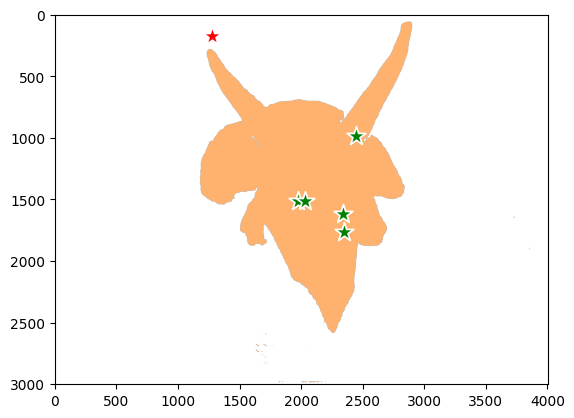

In [ ]:
init_fig = plt.figure()
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
init_fig.savefig(os.path.join(video_dir,"init_seg.png"))

In [ ]:
video_segments = {}
# 正向传播
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    } # obj_id指示的是多个分割目标，这里只有一个


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


In [ ]:
novel_mask = video_segments[1][obj_id] # bool
novel_mask = np.array(novel_mask)
gt_mask_pth = glob.glob(os.path.join(masks_dir,'*mask.png'))
gt_mask = Image.open(*gt_mask_pth)
gt_mask = np.array(gt_mask)

def calculate_iou(mask_pred, mask_gt):
    """
    计算两个布尔型掩码之间的IoU
    
    参数:
        mask_pred (np.ndarray): 预测掩码(布尔型或0-1)
        mask_gt (np.ndarray): 真实掩码(布尔型或0-1)
    
    返回:
        float: IoU值(0-1之间)
    """
    # 确保输入为布尔型或0-1数值
    mask_pred = mask_pred.astype(bool)
    mask_gt = mask_gt.astype(bool)
    
    # 计算交集和并集
    intersection = np.logical_and(mask_pred, mask_gt)
    union = np.logical_or(mask_pred, mask_gt)
    
    # 避免除以零的情况
    union_sum = np.sum(union)
    if union_sum == 0:
        return 0.0  # 如果两个掩码都是全零，定义IoU为0
    
    iou = np.sum(intersection) / union_sum
    return float(iou)
IoU = calculate_iou(novel_mask, gt_mask)
print(f"==>> IoU: {IoU}")

==>> IoU: 0.9713065574078237
